In [42]:
import sys
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = stdout
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('classic')
matplotlib.rcdefaults()

import matplotlib.pylab as pylab
params = {'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
pylab.rcParams.update(params)
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [100]:
# %load batch_combine_up.py
"""
Created on Wed Oct 25 12:23:39 2017

@author: yuxinlin
"""
import numpy as np
import os 

from astropy import units as u
from astropy import wcs
from astropy import coordinates
from astropy.io import fits
from astropy.convolution import convolve_fft, Gaussian2DKernel
from astropy.nddata.utils import Cutout2D
from astropy import wcs,stats
from astropy import convolution

from FITS_tools.hcongrid import hcongrid,hcongrid_hdu
import FITS_tools
import montage_wrapper as mw
import radio_beam
import image_registration
import AG_fft_tools as fft_tools
import image_registration.chi2_shifts as chi2_shifts 
from skimage.morphology import disk,erosion,opening
from photutils import CircularAperture

import uvcombine
from uvcombine import feather_kernel,fftmerge, feather_compare,file_in

import pylab as pl
import matplotlib.pyplot as plt



import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import misc
 
def butter2d_lp(shape, f, n, pxd=1):
    """Designs an n-th order lowpass 2D Butterworth filter with cutoff
   frequency f. pxd defines the number of pixels per unit of frequency (e.g.,
   degrees of visual angle)."""
    pxd = float(pxd)
    rows, cols = shape[0],shape[1]
    x = np.linspace(-0.5, 0.5, cols)  * cols / pxd
    y = np.linspace(-0.5, 0.5, rows)  * rows / pxd
    radius = np.sqrt((x**2)[np.newaxis] + (y**2)[:, np.newaxis])
    filt = 1 / (1.0 + (radius / f)**(2*n))
    return filt
 
def butter2d_bp(shape, cutin, cutoff, n, pxd=1):
    """Designs an n-th order bandpass 2D Butterworth filter with cutin and
   cutoff frequencies. pxd defines the number of pixels per unit of frequency
   (e.g., degrees of visual angle)."""
    return butter2d_lp(shape,cutoff,n,pxd) - butter2d_lp(shape,cutin,n,pxd)
 
def butter2d_hp(shape, f, n, pxd=1):
    """Designs an n-th order highpass 2D Butterworth filter with cutin
   frequency f. pxd defines the number of pixels per unit of frequency (e.g.,
   degrees of visual angle)."""
    return 1. - butter2d_lp(shape, f, n, pxd)





def feather_kernel_md(nax2, nax1, lowresfwhm, hiresfwhm, pixscale):
    """
    Construct the weight kernels (image arrays) for the fourier transformed low
    resolution and high resolution images.  The kernels are the fourier transforms
    of the low-resolution beam and (1-[that kernel])
    Parameters
    ----------
    nax2, nax1 : int
       Number of pixels in each axes.
    lowresfwhm : float
       Angular resolution of the low resolution image (FWHM)
    pixscale : float (?)
       pixel size in the input high resolution image.
    Return
    ----------
    kfft : float array
       An image array containing the weighting for the low resolution image
    ikfft : float array
       An image array containing the weighting for the high resolution image
       (simply 1-kfft)
    """
    # note for Baobab:
    # pixel indices 1 and -1 correspond to a sine with period equal to the full
    # image size
    # pixel index 0 corresponds to the zero-spacing, i.e. the mean of the image


    # Construct arrays which hold the x and y coordinates (in unit of pixels)
    # of the image
    ygrid,xgrid = (np.indices([nax2,nax1]) -
                   np.array([(nax2-1.)/2,(nax1-1.)/2.])[:,None,None])

    # constant converting "resolution" in fwhm to sigma
    fwhm = np.sqrt(8*np.log(2))

    # sigma in pixels
    sigma = ((lowresfwhm/fwhm/(pixscale*u.deg)).decompose().value)
    sigmahi = ((hiresfwhm/fwhm/(pixscale*u.deg)).decompose().value)
    # not used, just noted that these are the theoretical values (...maybe...)
    #sigma_fftspace = (1/(4*np.pi**2*sigma**2))**0.5
    #sigma_fftspace = (2*np.pi*sigma)**-1
    #log.debug('sigma = {0}, sigma_fftspace={1}'.format(sigma, sigma_fftspace))

    # technically, the fftshift here does nothing since we're using the
    # absolute value of the kernel below, so the phase is irrelevant
    kernel = np.fft.fftshift(np.exp(-(xgrid**2+ygrid**2)/(2*sigma**2)))
    kernelhi = np.fft.fftshift(np.exp(-(xgrid**2+ygrid**2)/(2*sigmahi**2)))
    #plt.imshow(kernel.real)
    #plt.show()
    # convert the kernel, which is just a gaussian in image space,
    # to its corresponding kernel in fourier space
    kfft = np.abs(np.fft.fft2(kernel)) # should be mostly real
    kffthi = np.abs(np.fft.fft2(kernelhi))
    if np.any(np.isnan(kfft)):
        raise ValueError("NaN value encountered in kernel")

    # normalize the kernel
    kfft/=kfft.max()
    kffthi/=kffthi.max()
    ikfft = 1-kfft
    plt.show()
    return kfft, ikfft,kffthi



def fftmerge_bw(kfft, ikfft,kffthi,im_hi, im_lo,pix, bw_center, bw_width,nbw, highpassfilterSD=False,
             replace_hires=False, deconvSD=False, min_beam_fraction=0.1,loconvhi=False, bwdo=True):
    """
    Same function as fftmerge in uvcombine while return the (deconvolved) low-resolution image together
    """
    
    fft_hi = np.fft.fft2(np.nan_to_num(im_hi))
    fft_lo = np.fft.fft2(np.nan_to_num(im_lo))
    #plt.imshow(fft_hi.real)
    #plt.show()
    bw_f = (bw_center-bw_width/2.)/pix
    bw = butter2d_hp(im_hi.shape,bw_f,nbw,pxd=1.)
    print im_hi.shape, bw_f, bw_center, bw_width, pix
    #plt.imshow(bw,vmin=0,vmax=1)
    bw_fft = np.abs(np.fft.ifft2(np.fft.fft2(np.fft.fftshift(bw))))
    bw_fft/=bw_fft.max()
    plt.plot(ikfft[:,2], color='red',alpha=0.3,label='ikfft--weight hi')
    plt.plot(kffthi[:,2],color='blue',alpha=0.3,label='kffthi--weight lo')
    plt.plot(bw_fft[:,2], color='red',label='bw_fft--weight hi')
   
    #plt.imshow(bw_fft.real)
    #plt.show()
    bw_ffti = 1-bw_fft
    
    plt.plot(bw_ffti[:,2],color='blue',label='bw_ifft--weight lo')
    print (kffthi*bw_ffti).shape,'bw_ifft*kffthi shape'
    plt.plot((kffthi*bw_ffti)[:,2],color='blue',linestyle='--',alpha=0.3, 
            label='bw_ifft*kffthi--weight lo')
    plt.legend()
    plt.title('bwfft')
    plt.show()
    #plt.imshow(bw_fft)
    # Combine and inverse fourier transform the images
    if highpassfilterSD:
        lo_conv = kfft*fft_lo
    elif deconvSD:
        lo_conv = fft_lo / kfft
        lo_conv[np.abs(kfft) < min_beam_fraction] = fft_lo[np.abs(kfft) < min_beam_fraction]
    else:
        lo_conv = fft_lo


    if replace_hires:
        if replace_hires is True:
            raise ValueError("If you are specifying replace_hires, "
                             "you must give a floating point value "
                             "corresponding to the beam-fraction of the "
                             "single-dish image below which the "
                             "high-resolution data will be used.")
        fftsum = lo_conv.copy()

        # mask where the hires data is above a threshold
        mask = ikfft > replace_hires

        fftsum[mask] = fft_hi[mask]
    else:
        fftsum = lo_conv + ikfft*fft_hi
        #plt.imshow(ikfft)
        #plt.title('ikfft')
        #plt.show()
    if bwdo:
        fftsum = lo_conv*kffthi*bw_ffti+fft_hi*bw_fft
        fftsum = lo_conv+fft_hi*bw_fft
        print 'butterworth!!'
        #plt.imshow(bw_fft)
        #plt.title('bwfft')
        #plt.show()
    combo = np.fft.ifft2(fftsum)
    #plt.imshow(combo.real)
    #plt.show()
    return fftsum, combo,np.fft.ifft2(lo_conv).real, (np.fft.ifft2(lo_conv*kffthi).real)


def fftmerge_verbose(kfft, ikfft,kffthi,im_hi, im_lo,  highpassfilterSD=False,
             replace_hires=False, deconvSD=False, min_beam_fraction=0.1,loconvhi=False):
    """
    Same function as fftmerge in uvcombine while return the (deconvolved) low-resolution image together
    """

    fft_hi = np.fft.fft2(np.nan_to_num(im_hi))
    fft_lo = np.fft.fft2(np.nan_to_num(im_lo))

    # Combine and inverse fourier transform the images
    if highpassfilterSD:
        lo_conv = kfft*fft_lo
    elif deconvSD:
        lo_conv = fft_lo / kfft
        lo_conv[np.abs(kfft) < min_beam_fraction] = fft_lo[np.abs(kfft) < min_beam_fraction]
    else:
        lo_conv = fft_lo


    if replace_hires:
        if replace_hires is True:
            raise ValueError("If you are specifying replace_hires, "
                             "you must give a floating point value "
                             "corresponding to the beam-fraction of the "
                             "single-dish image below which the "
                             "high-resolution data will be used.")
        fftsum = lo_conv.copy()

        # mask where the hires data is above a threshold
        mask = ikfft > replace_hires

        fftsum[mask] = fft_hi[mask]
    else:
        fftsum = lo_conv*kffthi + ikfft*fft_hi
    
    combo = np.fft.ifft2(fftsum)

    return fftsum, combo,np.fft.ifft2(lo_conv).real, (np.fft.ifft2(lo_conv*kffthi).real)

def convert_pmw(pmw_file,pmw_Jybeam_file,beamsize=30.3):
    """
    Convert SPIRE image from default Mjy/sr to Jy/beam
    """
    pmw_hdu = fits.open(pmw_file)
    pmw_Jybeam_header = pmw_hdu[0].header
   
    beam = np.pi*beamsize**2/(4*np.log(2))
    conv_factor = (u.MJy/u.sr).to(u.Jy/u.arcsec**2)*beam
    fits.writeto(pmw_Jybeam_file,pmw_hdu[0].data*conv_factor,header=pmw_Jybeam_header,overwrite=True)
    fits.setval(pmw_Jybeam_file,'BUNIT',value='Jy/beam')
    return 1
    
def detect_saturation(pmw_Jyarcsec_file, saboca_temp_Jyarcsec,gaussdb=False):
    #after deconvolution the larger SPIRE image and regrid it to the size of SABOCA (wounld by pwm_Jyarcsec_file 
    #from the following functions), check for now whether 
    #the image is saturated in the central region
    pmw_Jyarcsec_data = fits.getdata(pmw_Jyarcsec_file)
    saboca_temp_Jyarcsec_data = fits.getdata(saboca_temp_Jyarcsec)
    sourcename = re.split('temp|temp', pmw_Jyarcsec_file)[0]        
    if np.sum(np.isnan(pmw_Jyarcsec_data[~(saboca_temp_Jyarcsec_data==0)]))>0:
        return 1
    else:
        return 0
def erode_edge(saboca_temp_Jyarcsec, edge = 10, pixelsize=1.85):
    saboca_temp_Jyarcsec_data = fits.getdata(saboca_temp_Jyarcsec)
    saboca_temp_Jyarcsec_data[saboca_temp_Jyarcsec_data==0] = np.nan
    mask=np.isfinite(saboca_temp_Jyarcsec_data)
    mask2=erosion(mask, disk(edge/1.85))
   
    saboca_temp_Jyarcsec_data_ero = saboca_temp_Jyarcsec_data/mask2
    saboca_temp_Jyarcsec_data_ero[np.isnan(saboca_temp_Jyarcsec_data_ero)|np.isinf(saboca_temp_Jyarcsec_data_ero)] = 0.
    fits.writeto(saboca_temp_Jyarcsec[:-5]+'_ero.fits',saboca_temp_Jyarcsec_data_ero,
                 header=fits.getheader(saboca_temp_Jyarcsec),overwrite=True)
    print saboca_temp_Jyarcsec[:-5]+'_ero.fits'
    return 1



def regrid(hd1,im1,im2raw,hd2):
    # Sanity Checks:
    assert hd2['NAXIS'] == im2raw.ndim == 2, 'Error: Input lores image dimension non-equal to 2.'
    assert hd1['NAXIS'] == im1.ndim == 2, 'Error: Input hires image dimension non-equal to 2.'

    # read pixel scale from the header of high resolution image
    pixscale = FITS_tools.header_tools.header_to_platescale(hd1)
    #log.debug('pixscale = {0}'.format(pixscale))

    # read the image array size from the high resolution image
    nax1,nax2 = (hd1['NAXIS1'],
                 hd1['NAXIS2'],
                )

    # create a new HDU object to store the regridded image
    hdu2 = fits.PrimaryHDU(data=im2raw, header=hd2)

    # regrid the imageß
    hdu2 = hcongrid_hdu(hdu2, hd1)
    im2 = hdu2.data.squeeze()

    # return variables
    return hdu2, im2, nax1, nax2, pixscale


def regist_saboca_hers(dirpath,saboca_file,pmw_Jybeam_file,shifted_saboca_file,sn_i,verbose=False):
    """
    Register SABOCA astrometry to match SPIRE
    """
    pmw_hdu = fits.open(pmw_Jybeam_file)
    saboca_hdu = fits.open(saboca_file)
    hdu2, im2, nax1, nax2, pixscale = regrid(saboca_hdu[0].header,saboca_hdu[0].data,pmw_hdu[0].data,pmw_hdu[0].header)
    fits.writeto(dirpath+sn_i+'temp.fits',im2,header=saboca_hdu[0].header,overwrite=True)
    
    #use chi2_shift based on FFT
    pmw_hdu_regrid = fits.open(dirpath+sn_i+'temp.fits')
    dx,dy,edx,edy = chi2_shifts.chi2_shift(pmw_hdu_regrid[0].data,saboca_hdu[0].data,return_error=True)
    #fits.writeto(shifted_saboca_file,saboca_hdu[0].data,header=saboca_hdu[0].header,overwrite=True)
    #fits.setval(shifted_saboca_file,'CRPIX1',value=saboca_hdu[0].header['CRPIX1']+dx)
    #fits.setval(shifted_saboca_file,'CRPIX2',value=saboca_hdu[0].header['CRPIX2']+dy)
    
    result = image_registration.cross_correlation_shifts_FITS(
    dirpath+sn_i+'temp.fits', saboca_file, return_cropped_images=True,
    return_error=False, 
    register_method=image_registration.chi2_shift, verbose=True)


    xoff,yoff,xoff_wcs,yoff_wcs,herschel_reproj,saboca_reproj = result

    saboca_hdu = pmw_hdu_regrid[0].copy()
    saboca_hdu.data = saboca_reproj
    saboca_hdu.data[np.isnan(saboca_hdu.data)] = 0.
    saboca_hdu.writeto(shifted_saboca_file, overwrite=True)    
  
    if verbose:
        print 'shifted length (dx, dy):', xoff, yoff

    os.remove(dirpath+sn_i+'temp.fits')
    return 1
    
def feather_compare_md(dirpath,
                    sourcename,hires, lores,
                    SAS,
                    LAS,
                    hiresfwhm,
                    lowresfwhm,
                    beam_divide_lores=True,
                    highpassfilterSD=False,
                    min_beam_fraction=0.1,
                    plot_min_beam_fraction=1e-3,
                    doplot=True,
                    return_samples=False,
                    loconvhi=False):
    """
    Similar as feather_compare in uvcombine with trivial changes on plotting genre
    """
    assert LAS > SAS
    hdu_hi, im_hi, header_hi = file_in(hires)
    hdu_low, im_lowraw, header_low = file_in(lores)
    
    hdu_low, im_low, nax1, nax2, pixscale = regrid(header_hi, im_hi,
                                                   im_lowraw, header_low)
    im_low[im_hi<=0]=0.
    im_hi[im_hi<0]=0.
    #plt.imshow(im_low)
    #plt.clf()
    #plt.imshow(im_hi)
    kfft, ikfft,kffthi = feather_kernel_md(nax2, nax1,lowresfwhm,hiresfwhm,pixscale)
    kfft = np.fft.fftshift(kfft)
    ikfft = np.fft.fftshift(ikfft)
    kffthi = np.fft.fftshift(kffthi)
    yy,xx = np.indices([nax2, nax1])
    rr = ((xx-(nax1-1)/2.)**2 + (yy-(nax2-1)/2.)**2)**0.5
    angscales = nax1/rr * pixscale*u.deg
    
    fft_hi = np.fft.fftshift(np.fft.fft2(np.nan_to_num(im_hi)))
    fft_lo = np.fft.fftshift(np.fft.fft2(np.nan_to_num(im_low)))
    if beam_divide_lores:
        fft_lo_deconvolved = fft_lo / kfft
    else:
        fft_lo_deconvolved = fft_lo
    if loconvhi:
        fft_lo_deconvolved = fft_lo_deconvolved*kffthi
        
    
    below_beamscale = kfft < min_beam_fraction
    below_beamscale_plotting = kfft < plot_min_beam_fraction
    fft_lo_deconvolved[below_beamscale_plotting] = np.nan

    mask = (angscales > SAS) & (angscales < LAS) & (~below_beamscale)
    assert mask.sum() > 0

    ratio = np.abs(fft_hi)[mask] / np.abs(fft_lo_deconvolved)[mask]
    sclip = stats.sigma_clipped_stats(ratio, sigma=3, iters=5)

    if doplot:
        import pylab as pl
        fig = plt.figure(figsize=(12,8))
        pl.clf()
        pl.suptitle("{0} - {1}".format(SAS,LAS))
        pl.subplot(2,2,1)
        pl.plot(np.abs(fft_hi)[mask], np.abs(fft_lo_deconvolved)[mask], '.')
        mm = [np.abs(fft_hi)[mask].min(), np.abs(fft_hi)[mask].max()]
        pl.plot(mm, mm, 'm--', label='equal')
        pl.plot(mm, mm/sclip[1], 'k:',label='clipped')
        pl.xlabel("High-resolution")
        pl.ylabel("Low-resolution")
        pl.legend(loc=3)
        pl.subplot(2,2,2)

        pl.hist(ratio[np.isfinite(ratio)], bins=30)
        
        pl.xlabel("High-resolution / Low-resolution flux ratio")
        pl.subplot(2,1,2)
        srt = np.argsort(angscales.to(u.arcsec).value[~below_beamscale_plotting])
        pl.plot(angscales.to(u.arcsec).value[~below_beamscale_plotting][srt],
                np.nanmax(np.abs(fft_lo_deconvolved))*kfft.real[~below_beamscale_plotting][srt],
                'k-', zorder=-5)
        pl.xlabel('Angular scale (arcsec)')
        pl.ylabel('flux')
        pl.loglog(angscales.to(u.arcsec).value, np.abs(fft_hi), 'r,', alpha=0.5, label='High-res')
        pl.loglog(angscales.to(u.arcsec).value, np.abs(fft_lo_deconvolved), 'b,', alpha=0.5, label='Lo-res')
        ylim = pl.gca().get_ylim()
        pl.vlines([SAS.to(u.arcsec).value,LAS.to(u.arcsec).value],
                  ylim[0], ylim[1], linestyle='-', color='k')
        #pl.legend(loc='best')
        pl.savefig(dirpath+sourcename+'_compare_overlap_fluxes_1027.pdf')
    if return_samples:
        return (angscales.to(u.arcsec)[mask], ratio, np.abs(fft_hi)[mask],
                np.abs(fft_lo_deconvolved)[mask])

    return {'median': np.nanmedian(ratio),
            'mean': np.nanmean(ratio),
            'std': np.nanstd(ratio),
            'mean_sc': sclip[0],
            'median_sc': sclip[1],
            'std_sc': sclip[2],
           }
 
def flux_compare_md(dirpath,shifted_saboca_file,pmw_Jybeam_file,sn_i,
                    comb_file,bw_center, bw_width,nbw, pix=1.85,sab_beam=9.86,pmw_beam=30.3,
                    simple_combine=False,deconvSD=False,psd_plot=True,zoomin=False,
                    loconvhi=False,bwdo=False):
    """
    Similar as flux_compare in uvcombine
    Input files in Jy/beam unit
    Default plot power-spectrum result
    """
    shifted_saboca = fits.open(shifted_saboca_file)
    pmw_file = fits.open(pmw_Jybeam_file)
    shifted_saboca[0].data[np.isnan(shifted_saboca[0].data)] = 0.
    
    fits.writeto(dirpath+str(sn_i)+r'saboca_temp_Jyarcsec.fits',shifted_saboca[0].data/(np.pi*sab_beam**2/(4*np.log(2))),header=shifted_saboca[0].header,overwrite=True)
    #erode_edge(dirpath+str(sn_i)+r'saboca_temp_Jyarcsec.fits', edge = 20, pixelsize=1.85)
   # shifted_saboca[0].data = fits.getdata(dirpath+str(sn_i)+r'saboca_temp_Jyarcsec.fits')
    sn_sat = None
    #to see if herschel SPIRE map have saturated pixels in interested region   
    hdu2, im2, nax1, nax2, pixscale2 = regrid(shifted_saboca[0].header,shifted_saboca[0].data,pmw_file[0].data,pmw_file[0].header)
    pmw_Jyarcsec = im2/(np.pi*pmw_beam**2/(4*np.log(2)))
    fits.writeto(dirpath+str(sn_i)+r'pmw_temp_Jyarcsec.fits',pmw_Jyarcsec,header=shifted_saboca[0].header,overwrite=True)
    if deconvSD:
    #do the deconvolution for the low_im here
        lofwhm = pmw_beam
        fits_lo = pmw_file[0].data
        pixscale = np.abs(pmw_file[0].header['CDELT1']*3600.)
        y_size,x_size = fits_lo.shape
        lo_im = np.nan_to_num(fits_lo)
        singledish_kernel = convolution.Gaussian2DKernel(lofwhm/2.35/pixscale, x_size=x_size, y_size=y_size)
        singledish_kernel_fft = np.fft.fft2(singledish_kernel)
    
        #pl.imshow(singledish_kernel)
        #pl.imshow(np.abs(np.fft.fftshift(singledish_kernel_fft)))
        deconv_kernel = singledish_kernel_fft.copy()
        badpix = np.abs(deconv_kernel) < 1e-1
        imfft = np.fft.fft2(lo_im)
        naive_deconvolution_fft = (imfft / deconv_kernel)
        naive_deconvolution_fft[badpix] = imfft[badpix]
        naive_deconvolution = np.fft.ifft2(naive_deconvolution_fft)
        pmw_file[0].data = np.fft.fftshift(naive_deconvolution.real)
        print 'Direct deconvolution done!'
        hdu2, im2, nax1, nax2, pixscale2 = regrid(shifted_saboca[0].header,shifted_saboca[0].data,pmw_file[0].data,pmw_file[0].header)
        pmw_Jyarcsec = im2/(np.pi*pmw_beam**2/(4*np.log(2)))
        fits.writeto(dirpath+str(sn_i)+r'pmw_temp_deconv_Jyarcsec.fits',pmw_Jyarcsec,header=shifted_saboca[0].header,overwrite=True)
        #if loconvhi:
        #    hifwhm = sab_beam
        #    y_size,x_size = fits_lo.shape
        #    lo_im = np.nan_to_num(fits_lo)
        #    interdish_kernel = convolution.Gaussian2DKernel(hifwhm/2.35/pixscale, x_size=x_size, y_size=y_size)
        #    interdish_kernel_fft = np.fft.fft2(interdish_kernel)
    
            #pl.imshow(np.abs(np.fft.fftshift(singledish_kernel_fft)))
        #    conv_kernel = interdish_kernel_fft.copy()
        #    badpix = np.abs(conv_kernel) < 1e-1
            
        #    naive_deconv_fft_conv = naive_deconvolution_fft*conv_kernel
        #    naive_deconv_fft_conv[badpix] = imfft[badpix]
        #    naive_deconv_conv = np.fft.ifft2(naive_deconv_fft_conv)

        #    pmw_file[0].data = np.fft.fftshift(naive_deconv_conv.real)
        #    hdu2, im2, nax1, nax2, pixscale2 = regrid(shifted_saboca[0].header,shifted_saboca[0].data,pmw_file[0].data,pmw_file[0].header)
        #    pmw_Jyarcsec = im2/(np.pi*pmw_beam**2/(4*np.log(2)))
        #    fits.writeto(dirpath+str(sn_i)+r'pmw_temp_deconv_Jyarcsec_conv.fits',pmw_Jyarcsec,header=shifted_saboca[0].header,overwrite=True)
        scale_ratio = feather_compare_md(dirpath, str(sn_i),dirpath+str(sn_i)+r'saboca_temp_Jyarcsec.fits',dirpath+str(sn_i)+r'pmw_temp_deconv_Jyarcsec.fits',
                              sab_beam*u.arcsec,
                              60.*u.arcsec,
                              sab_beam*u.arcsec,
                              pmw_beam*u.arcsec,
                              min_beam_fraction=0.1,
                              doplot=False,
                              beam_divide_lores=False,
                                        loconvhi=loconvhi)
        
    else:
        scale_ratio = feather_compare_md(dirpath, str(sn_i),dirpath+str(sn_i)+r'saboca_temp_Jyarcsec.fits',dirpath+str(sn_i)+r'pmw_temp_Jyarcsec.fits',
                              sab_beam*u.arcsec,
                              60.*u.arcsec,
                              sab_beam*u.arcsec,
                              pmw_beam*u.arcsec,
                              min_beam_fraction=0.1,
                              doplot=False,
                              beam_divide_lores=False,
                                        loconvhi=loconvhi)
    if not simple_combine:
        pixscale = pixscale2
        lowresfwhm = pmw_beam*u.arcsec
        hiresfwhm =sab_beam*u.arcsec
        nax1,nax2 = im2.shape
        kfft, ikfft,kffthi = feather_kernel_md(nax1, nax2, lowresfwhm, hiresfwhm,pixscale,)
        # Feather the interferometer and single dish data back together
        # This uses the naive assumptions that CASA uses
        # However, there are a few flags that can be played with.
        # None of them do a whole lot, though there are good theoretical
        # reasons to attempt them.
        im_hi = shifted_saboca[0].data.real/(np.pi*sab_beam**2/(4*np.log(2)))
        im_low = pmw_Jyarcsec
        lowresscalefactor=1.
        replace_hires = False
        highpassfilterSD = False
        deconvSD1 = False
        highresscalefactor=1.0/scale_ratio['mean_sc']
        fftsum, combo,sd_deconvorig,sd_deconvconv= fftmerge_verbose(kfft, ikfft,kffthi, im_hi*highresscalefactor,
                                 im_low*lowresscalefactor,
                                 replace_hires=replace_hires,
                                 highpassfilterSD=highpassfilterSD,
                                 deconvSD=deconvSD1,
                                 loconvhi=loconvhi,
                                )  
        fits.writeto(comb_file,combo.real*(np.pi*sab_beam**2/(4*np.log(2))),header=shifted_saboca[0].header,
                     overwrite=True) 
        if bwdo:
            fftsumbw, combobw,sd_deconvorigbw,sd_deconvconvbw= fftmerge_bw(kfft, ikfft,kffthi, im_hi*highresscalefactor,
                                 im_low*lowresscalefactor,pix,bw_center, bw_width, nbw,
                                 replace_hires=replace_hires,
                                 highpassfilterSD=highpassfilterSD,
                                 deconvSD=deconvSD1,
                                 loconvhi=loconvhi,
                                 bwdo=True
                                )
            fits.writeto(dirpath+str(sn_i)+r'_bw.fits',combobw.real*(np.pi*sab_beam**2/(4*np.log(2))),
                         header=shifted_saboca[0].header,overwrite=True) 
            print dirpath+str(sn_i)+r'_bw.fits'
        sd_deconvorig[im_hi==0.] = 0.
        sd_deconvconv[im_hi==0.] = 0.
        combo.real[im_hi==0.] = 0.
        #plt.imshow(sd_deconvorig)
        #plt.show()
        frequency0,zz0 = fft_tools.PSD2(im_hi,fft_pad=True,oned=True,view=False,wavnum_scale=False)
        print 'high resolution image scaling factor:',highresscalefactor
        frequency1,zz1 = fft_tools.PSD2(im_hi*highresscalefactor,fft_pad=True,oned=True,view=False,wavnum_scale=False)
        frequency2,zz2 = fft_tools.PSD2(sd_deconvconv,fft_pad=True,oned=True,view=False,wavnum_scale=False)
        frequency3,zz3 = fft_tools.PSD2(combo.real,fft_pad=True,oned=True,view=False,wavnum_scale=False)
        frequency4,zz4 = fft_tools.PSD2(sd_deconvorig,fft_pad=True,oned=True,view=False,wavnum_scale=False)
      
        
        #save the first point where psd of saboca drops below psd of herschel        
        fig1 = plt.figure(figsize=(6,6))
        ax1 = fig1.add_subplot(111)
        ax2 = ax1.twiny()

        #save the first point where psd of saboca drops below psd of herschel
        #cutpoint = frequency1[zz1>zz2][0]
        ax1.plot((frequency0),(zz0),linewidth=2.5,color='blue',linestyle='--',alpha=0.2,label='original SABOCA')

        ax1.plot((frequency1),(zz1),linewidth=1.5,color='blue',label='rescaled SABOCA')
        ax1.plot((frequency2),(zz2),linewidth=2.5,color='red',label='deconv SPIRE convolved with hi'if deconvSD else 'SPIRE convolved with hi')
        ax1.plot((frequency3),(zz3),linewidth=2.5,color='green',label='combined SABOCA+deconv SPIRE' 
                 if deconvSD else 'combined SABOCA+SPIRE')
        ax1.plot((frequency4),(zz4),linewidth=2.5,color='red',linestyle='--',label='deconv SPIRE' 
                 if deconvSD else 'SPIRE')
        if bwdo:
            combobw.real[im_hi==0.] = 0.

            frequency6,zz6 = fft_tools.PSD2(combobw.real,fft_pad=True,oned=True,view=False,wavnum_scale=False)
            ax1.plot((frequency6),(zz6),linewidth=1.5,color='magenta',linestyle='--',label='butterworth')

        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax1.set_xlim(3*10**-3,1)
        ax1.set_xlabel('freq.')
        ax1.set_ylabel('P')
        if zoomin: 
            ax1.set_xlim(0.03,0.3)
            ax1.set_ylim(0.1,100)

        #add beam scale
        pixscale = ((pixscale*u.deg).to(u.arcsec)).value
        beam_saboca_freq = 1./(sab_beam/pixscale)
        beam_spire_freq = 1./(pmw_beam/pixscale)
        ax1.axvline(x=beam_saboca_freq,linestyle=':',color='k',alpha=0.3,label='beam SABOCA')
        ax1.axvline(x=beam_spire_freq,linestyle='-',color='k',alpha=0.3,label='beam SPIRE')
        #plt.axvline(x=cutpoint, linestyle='-',color='magenta',alpha=0.3, label='LAS')
        ax1.legend(frameon=False,fontsize=8,loc=3)
        #spscale = (1./cutpoint)*pixscale
        
        #add another axis displaying angular scales
        # get the primary axis x tick locations in plot units
        xtickloc = ax1.get_xticks() 
        # set the second axis ticks to the same locations
        ax2.set_xticks(xtickloc)
        # calculate new values for the second axis tick labels, format them, and set them
        #print xtickloc, 'now'
        def conv(xtickloc):
            return 1./xtickloc*pixscale
        x2labels = ['{:.3g}'.format(x) for x in conv(xtickloc)]
        #print 'check values',x2labels
        
        ax2.set_xticklabels(x2labels)
        #print 'done'
        # force the bounds to be the same
        ax2.set_xlim(ax1.get_xlim()) 
        ax2.set_xscale('log')
        ax2.set_xticklabels(x2labels)

        #ax2.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        #plt.gca().ax2.set_major_formatter(mtick.FormatStrFormatter('%.1f')) 
        ax2.set_xlabel('angular scale (arcsec)')
        fig1.savefig(dirpath+str(sn_i)+'_rescale_psd_1027.pdf')
        plt.show()
 
        fits.writeto(dirpath+str(sn_i)+r'pmw_temp_deconv_Jyarcsec_conv.fits',sd_deconvorig,header=shifted_saboca[0].header,
                    overwrite=True,)
        
    if simple_combine:
        #print "scale_ratio", scale_ratio['median_sc']
        if scale_ratio['median_sc'] >1:
        #scale ratio is the flux ratio of hi/low in overlapping uv regions
                print '1 case'
                print dirpath+str(sn_i)+r'saboca_temp_Jyarcsec.fits',dirpath+str(sn_i)+r'pmw_temp_Jyarcsec.fits'
                result = uvcombine.feather_simple(dirpath+str(sn_i)+r'saboca_temp_Jyarcsec.fits',
                                            dirpath+str(sn_i)+r'pmw_temp_Jyarcsec.fits',
                                            highresextnum=0,
                                            lowresextnum=0,
                                            highresscalefactor=1.0/scale_ratio['median_sc'],
                                            lowresscalefactor=1.0,#*scale_ratio['median_sc'],
                                            lowresfwhm=pmw_beam*u.arcsec,
                                            highpassfilterSD=False,
                                            replace_hires=False,
                                            deconvSD=False,match_units=False)
        else: 
            print '2 case'
            result = uvcombine.uvcombine.feather_simple(dirpath+str(sn_i)+r'saboca_temp_Jyarcsec.fits',
                                            dirpath+str(sn_i)+r'pmw_temp_Jyarcsec.fits',
                                            highresextnum=0,
                                            lowresextnum=0,
                                            highresscalefactor=1.0/scale_ratio['mean_sc'],
                                            lowresscalefactor=1.0,
                                            lowresfwhm=pmw_beam*u.arcsec,
                                            highpassfilterSD=False,
                                            replace_hires=False,
                                            deconvSD=False,match_units=False)

        comb_data = result.real
        fits.writeto(comb_file, comb_data*(np.pi*sab_beam**2/(4*np.log(2))),header=shifted_saboca[0].header,overwrite=True)
    spscale = 1.
    return scale_ratio, sn_sat, combo.real*(np.pi*sab_beam**2/(4*np.log(2))),im2/(np.pi*pmw_beam**2/(4*np.log(2))),spscale
    

def match_psf_aniano(herschel_file_regrid,kernel_file,):
     
    hers_hdu = fits.open(herschel_file_regrid)
    spire_psf_hdu = fits.open(r'/Users/yuxinlin/kernels_aniano/self_kernel/Kernel_HiRes_SPIRE_350_to_SPIRE_350.fits')
    
    #regrid directly to the pixel size of combined Laboca+planck
    
    large_pixel = hers_hdu[0].header['CDELT1']
    small_pixel = spire_psf_hdu[0].header['CD1_1']
    
    downsample_factor = np.abs(large_pixel/small_pixel)
    new_header = spire_psf_hdu[0].header.copy()
    
    new_header['CD1_1'] *= downsample_factor
    new_header['CD2_2'] *= downsample_factor
    new_header['NAXIS1'] /= downsample_factor
    new_header['NAXIS2'] /= downsample_factor
    new_header['CRPIX1'] = (new_header['CRPIX1']-1)/downsample_factor+1
    new_header['CRPIX2'] = (new_header['CRPIX2']-1)/downsample_factor+1
    #new_header['RADESYS'] = 'fk5'
    
    spire_psf_downsampled_hdu = fits.PrimaryHDU(image_registration.fft_tools.downsample.downsample(spire_psf_hdu[0].data,
                                                                                              factor=np.int(downsample_factor)).real,
                                             header=new_header)
                                             
    
    return 1

Coarse xmax/ymax = 102,120, for offset -2.000000,3.000000
Minimum chi2: 1.61326e+08   Max delta-chi2 (lowres): 221692  Min delta-chi2 (lowres): 33.3374
Selected upsample factor 256.0 for image size 512 and zoom factor 2.0 (max-sigma range was 1 for area 1)
Minimum chi2_ups: 1.61326e+08   Max delta-chi2 (highres): 2379.34  Min delta-chi2 (highres): 0.00312611
Direct deconvolution done!


/Users/yuxinlin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:380: RuntimeWarning: divide by zero encountered in divide


high resolution image scaling factor: 4.71159213304


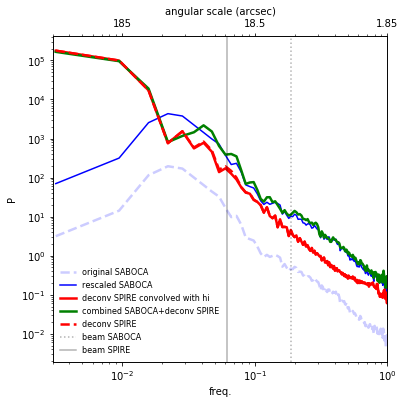

high resolution image scaling factor: 3.49687891201


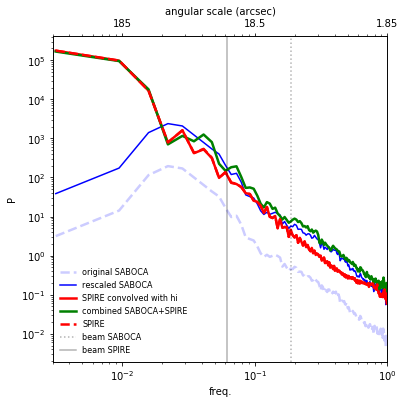

(235, 209) 10.8108108108 30 20 1.85
(235, 209) bw_ifft*kffthi shape


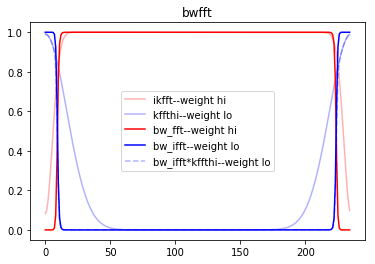

butterworth!!
/Users/yuxinlin/saboca_sources/SPIRE_cut/SPIRE_350/temp/AG1.67_0.13_bw.fits
high resolution image scaling factor: 3.49687891201


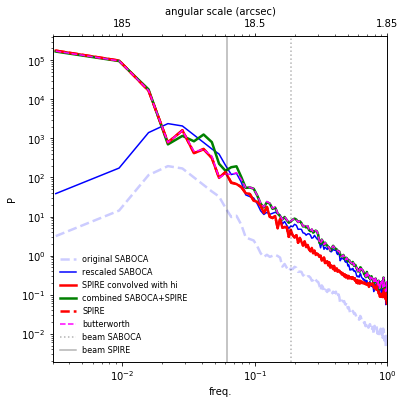

scaling factor (deconvolved vs. no deconv): {'std': 0.16855454472830111, 'median': 0.20043917259066107, 'mean_sc': 0.21224248019842798, 'std_sc': 0.10054370378678132, 'median_sc': 0.19162904075247661, 'mean': 0.24799087632500283} vs. {'std': 0.21424153402599441, 'median': 0.24070572956219663, 'mean_sc': 0.28596929581028951, 'std_sc': 0.16840061107647925, 'median_sc': 0.2314637777936735, 'mean': 0.30905315308211373}


In [101]:
import glob
import re
import subprocess

saboca_file_path = r'/Users/yuxinlin/saboca_sources/all_new_red_data/new_try_all/9046/'
pmw_cut_file_path = r'/Users/yuxinlin/saboca_sources/SPIRE_cut/SPIRE_350/'
combined_path = r'/Users/yuxinlin/saboca_sources/combined350_l3/'    

filelist_SABOCA = r'/Users/yuxinlin/saboca_sources/reduced_source_table.dat'

sourcename,ra_list,dec_list = np.loadtxt(filelist_SABOCA,usecols=[0,1,2],dtype={'names': ('sn', 'ra', 'dec'),
                                        'formats': ('S15', 'f4', 'f4')},skiprows=1,unpack=True)
orig_table= np.loadtxt(r'/Users/yuxinlin/saboca_sources/reduced_source_table_info.dat',skiprows=1,usecols=(0,1,2,3,4,5),
                           dtype={'names': ('source','ra','dec','proj','rms','peak'),'formats': ('S15', 'f8', 'f8','S18','f8', 'f8')})
calibration_dict = {}
psd_drop_dict = {}
rms = orig_table['rms']
#a faint source
sourcename = ['AG1.67-0.13']
#a bright source
for i, sn_i in enumerate(sourcename[:]):
    pmw_file_fd = glob.glob1(pmw_cut_file_path+r'repro/',str(sn_i)+'*repro2.fits')
    if len(pmw_file_fd)>0:
            saboca_file_fd = glob.glob1(saboca_file_path,str(sn_i)+'*.fits')
            saboca_file = saboca_file_path+saboca_file_fd[0]

            pmw_file = pmw_cut_file_path+r'repro/'+pmw_file_fd[0]
            pmw_file_hdu = fits.open(pmw_file)
            sat_all = []
    #            if pmw_file_hdu[0].header['CTYPE1'] is not "RA---TAN":
    #                mw.reproject(pmw_cut_file_path+pmw_file_fd[0],pmw_cut_file_path+pmw_file_fd[0]+'_repro.fits',north_aligned=True,header=None,system='GAL',equinox='2000')
    #                mw.reproject(pmw_cut_file_path+pmw_file_fd[0]+'_repro.fits',pmw_cut_file_path+pmw_file_fd[0]+'_repro2.fits',north_aligned=True,header=None,system='EQUJ',equinox='2000') 
    #                pmw_file = pmw_cut_file_path+pmw_file_fd[0]+'_repro2.fits'
            rms_saboca = np.float(rms[np.argwhere(orig_table['source']==sn_i)[0]])

            if '-' in sn_i:
               sn_i = sn_i.replace('-','_')
            if '+' in sn_i:
               sn_i = sn_i.replace('+','__')
        
            convert_pmw(pmw_file,pmw_cut_file_path+'temp/'+str(sn_i)+'_Jybeam.fits',beamsize=30.)
            regist_saboca_hers(pmw_cut_file_path+'temp/',saboca_file,
                                   pmw_cut_file_path+'temp/'+str(sn_i)+'_Jybeam.fits',
                                   pmw_cut_file_path+'temp/'+str(sn_i)+'_saboca_shifted.fits',str(sn_i))
            
            
            try: 
                #print 'write files', sn_i
                #print pmw_cut_file_path+'temp/'+str(sn_i)+'_saboca_shifted.fits'
                fits_lo = fits.open(pmw_cut_file_path+'temp/'+str(sn_i)+r'pmw_temp_Jyarcsec.fits')
                pmw_beam = 30.3
                fits_lo[0].data = fits_lo[0].data#/(np.pi*pmw_beam**2/(4*np.log(2)))
                

                sn_scale_dec, sat_sn_dec, combo1_dec, sd_deconv,drop_sc_dec=flux_compare_md(pmw_cut_file_path+'temp/',pmw_cut_file_path+'temp/'+str(sn_i)+'_saboca_shifted_ero.fits',
                             pmw_cut_file_path+'temp/'+str(sn_i)+'_Jybeam.fits',
                             str(sn_i),
                             combined_path+str(sn_i)+'_combined350_rs_spire_dcSD_fftmerge_1126_deconv.fits',
                            30,20,10,
                             sab_beam=9.86, pmw_beam=30.,simple_combine=False, deconvSD=True,loconvhi=False)
                sn_scale_nodec, sat_sn_nodec, combo1_nodec, sd_nodec,drop_sc_nodec=flux_compare_md(pmw_cut_file_path+'temp/',pmw_cut_file_path+'temp/'+str(sn_i)+'_saboca_shifted_ero.fits',
                             pmw_cut_file_path+'temp/'+str(sn_i)+'_Jybeam.fits',
                             str(sn_i),
                             combined_path+str(sn_i)+'_combined350_rs_spire_dcSD_fftmerge_1126_nodeconv.fits',
                            30, 20,10,
                             sab_beam=9.86, pmw_beam=30.,simple_combine=False, deconvSD=False,loconvhi=False)
                sn_scale_bw, sat_sn_bw, combo1_bw, sd_bw,drop_sc_bw=flux_compare_md(pmw_cut_file_path+'temp/',pmw_cut_file_path+'temp/'+str(sn_i)+'_saboca_shifted_ero.fits',
                             pmw_cut_file_path+'temp/'+str(sn_i)+'_Jybeam.fits',
                             str(sn_i),
                             combined_path+str(sn_i)+'_combined350_rs_spire_dcSD_fftmerge_1025_nodeconvbw.fits',
                             30, 20,10,
                             sab_beam=9.86, pmw_beam=30.,simple_combine=False, deconvSD=False,loconvhi=False,bwdo=True)

                print  'scaling factor (deconvolved vs. no deconv):',sn_scale_dec, 'vs.', sn_scale_nodec
                calibration_dict[str(sn_i)] = sn_scale_dec['median_sc']
                psd_drop_dict[str(sn_i)] = drop_sc_dec
                if sat_sn is not None:
                    sat_all = np.append(sat_all, sat_sn)
            except:
                next

Direct deconvolution done!


/Users/yuxinlin/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:380: RuntimeWarning: divide by zero encountered in divide


(235, 209) 9.72972972973 38.0 40.0 1.85
(235, 209) bw_ifft*kffthi shape


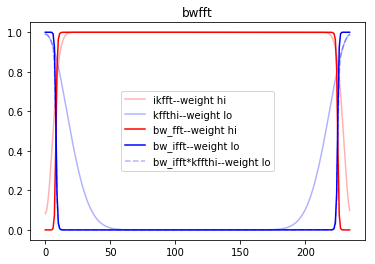

butterworth!!
/Users/yuxinlin/saboca_sources/SPIRE_cut/SPIRE_350/temp/AG1.67_0.13_bw.fits
high resolution image scaling factor: 4.02130013463


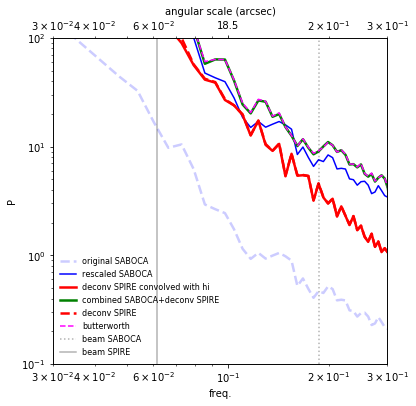

{'std': 0.20599372667709806, 'median': 0.23272594149504711, 'mean_sc': 0.2486757930322463, 'std_sc': 0.11813646746715857, 'median_sc': 0.21960924743397547, 'mean': 0.29548494904453743}


In [103]:
sn_scale_bw, sat_sn_bw, combo1_bw, sd_bw,drop_sc_bw=flux_compare_md(pmw_cut_file_path+'temp/',pmw_cut_file_path+'temp/'+str(sn_i)+'_saboca_shifted_ero.fits',
                             pmw_cut_file_path+'temp/'+str(sn_i)+'_Jybeam.fits',
                             str(sn_i),
                             combined_path+str(sn_i)+'_combined350_rs_spire_dcSD_fftmerge_1126_deconv.fits',
                             38.,40.,10,
                             sab_beam=9.86, pmw_beam=30.,simple_combine=False, deconvSD=True,loconvhi=True,bwdo=True,zoomin=True)
print sn_scale_bw

In [106]:
#the scale factor for hi image used by immerge
print 1./sn_scale_nodec['mean_sc']
print 1./sn_scale_dec['mean_sc']

3.49687891201
4.71159213304


In [86]:
#saboca image noise level (in Jy/beam)
rms_saboca
rms_saboca/(np.pi*8.0**2/(4*np.log(2)))

0.0016174016242053735

__In what follows immerge is used to combined the saboca image with orignal SPIRE image, with saboca image scale down with a factor of 0.58__

In [107]:
#combine using IMMERGE in miriad package, scaling factor as above
command = './merge.csh '+''+str(sn_i)+'_Jybeam '+''+str(sn_i)+'_saboca_shifted_ero '+''\
            +str(sn_i)+'_miriad_merge '+''+str(1./sn_scale_nodec['mean_sc'])
print "command and input parameters to merge.csh:", command.split()
subprocess.call(command.split(),shell=False)
            
    
if '__' in sn_i:
                
    tt = sn_i.replace('__','+')
else:
    tt = sn_i.replace('_','-')
os.rename(str(sn_i)+'_miriad_merge.fits',tt+'_miriad_merge_1027.fits')   
print 'miriad merge done!'

command and input parameters to merge.csh: ['./merge.csh', 'AG1.67_0.13_Jybeam', 'AG1.67_0.13_saboca_shifted_ero', 'AG1.67_0.13_miriad_merge', '3.49687891201']
miriad merge done!


In [88]:
print sn_i
print tt

AG1.67_0.13
AG1.67-0.13


In [212]:
%pwd
%less merge.csh

__In 'merge.csh' the SPIRE image is extra smoothed by a kernel size of 10'' before combination__

In [157]:
filelist_orig = glob.glob1(r'./',sn_i[:6]+'*.fits')
print filelist_orig, sn_i[:6]
filelist_comb = glob.glob1(combined_path,sn_i[:6]+'*.fits')
print filelist_comb
%pwd

['AG1.67-0.13_miriad_merge.fits', 'AG1.67-0.13_miriad_merge_1025.fits', 'AG1.67-0.13_miriad_merge_1026.fits', 'AG1.67-0.13_miriad_merge_1027.fits', 'AG1.67-0.13_miriad_merge_1027.fits_sm10.fits', 'AG1.67-0.13_miriad_merge_1027.sm10.fits', 'AG1.67_0.13_bw.fits', 'AG1.67_0.13_Jybeam.fits', 'AG1.67_0.13_Jybeam.miriad.regrid.fits', 'AG1.67_0.13_saboca_shifted.fits', 'AG1.67_0.13_saboca_shifted_ero.fits', 'AG1.67_0.13bw_merge.fits', 'AG1.67_0.13pmw_temp_deconv_Jyarcsec.fits', 'AG1.67_0.13pmw_temp_deconv_Jyarcsec_conv.fits', 'AG1.67_0.13pmw_temp_Jyarcsec.fits', 'AG1.67_0.13saboca_temp_Jyarcsec.fits'] AG1.67
['AG1.67_0.13_combined350_rs_spire_dcSD_fftmerge.fits', 'AG1.67_0.13_combined350_rs_spire_dcSD_fftmerge_0917.fits', 'AG1.67_0.13_combined350_rs_spire_dcSD_fftmerge_1025_deconv.fits', 'AG1.67_0.13_combined350_rs_spire_dcSD_fftmerge_1025_nodeconv.fits', 'AG1.67_0.13_combined350_rs_spire_dcSD_fftmerge_1025_nodeconvbw.fits', 'AG1.67_0.13_combined350_rs_spire_dcSD_fftmerge_1027_nodeconv.fits']

u'/Users/yuxinlin/saboca_sources/SPIRE_cut/SPIRE_350/temp'

/Users/yuxinlin/saboca_sources/SPIRE_cut/SPIRE_350/temp
(175, 149) (175, 149) (175, 149) (175, 149) (175, 149) (175, 149)


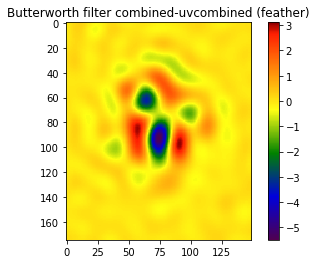

In [108]:
%cd /Users/yuxinlin/saboca_sources/SPIRE_cut/SPIRE_350/temp/
#plot all the images and histograms of fluxes
saboca_orig1 = fits.getdata(r'./AG1.67_0.13saboca_temp_Jyarcsec.fits',0)[30:-30,30:-30]
saboca_orig = fits.getdata(r'./AG1.67_0.13saboca_temp_Jyarcsec_ero.fits',0)[30:-30,30:-30]

spire_orig = fits.getdata(r'./AG1.67_0.13pmw_temp_Jyarcsec.fits',0)[30:-30,30:-30]
deconv_spire_orig = fits.getdata(r'./AG1.67_0.13pmw_temp_deconv_Jyarcsec.fits',0)[30:-30,30:-30]
deconv_spire_conv = fits.getdata(r'./AG1.67_0.13pmw_temp_deconv_Jyarcsec_conv.fits')[30:-30,30:-30]
comb_nodecon = fits.getdata(combined_path+r'AG1.67_0.13_combined350_rs_spire_dcSD_fftmerge_1126_nodeconv.fits',0)[30:-30,30:-30]
comb_decon = fits.getdata(combined_path+r'AG1.67_0.13_combined350_rs_spire_dcSD_fftmerge_1126_deconv.fits',0)[30:-30,30:-30]
comb_bw = fits.getdata(r'/Users/yuxinlin/saboca_sources/SPIRE_cut/SPIRE_350/temp/AG1.67_0.13_bw.fits',0)[30:-30,30:-30]

comb_miriad = fits.getdata(r'./AG1.67-0.13_miriad_merge_1027.fits',0)[30:-30,30:-30]
print saboca_orig.shape, spire_orig.shape, deconv_spire_orig.shape, comb_nodecon.shape, comb_decon.shape, comb_miriad.shape
plt.imshow(comb_bw-comb_decon)
#plt.imshow(saboca_orig-spire_orig)
plt.title('Butterworth filter combined-uvcombined (feather)')
plt.colorbar()
plt.show()

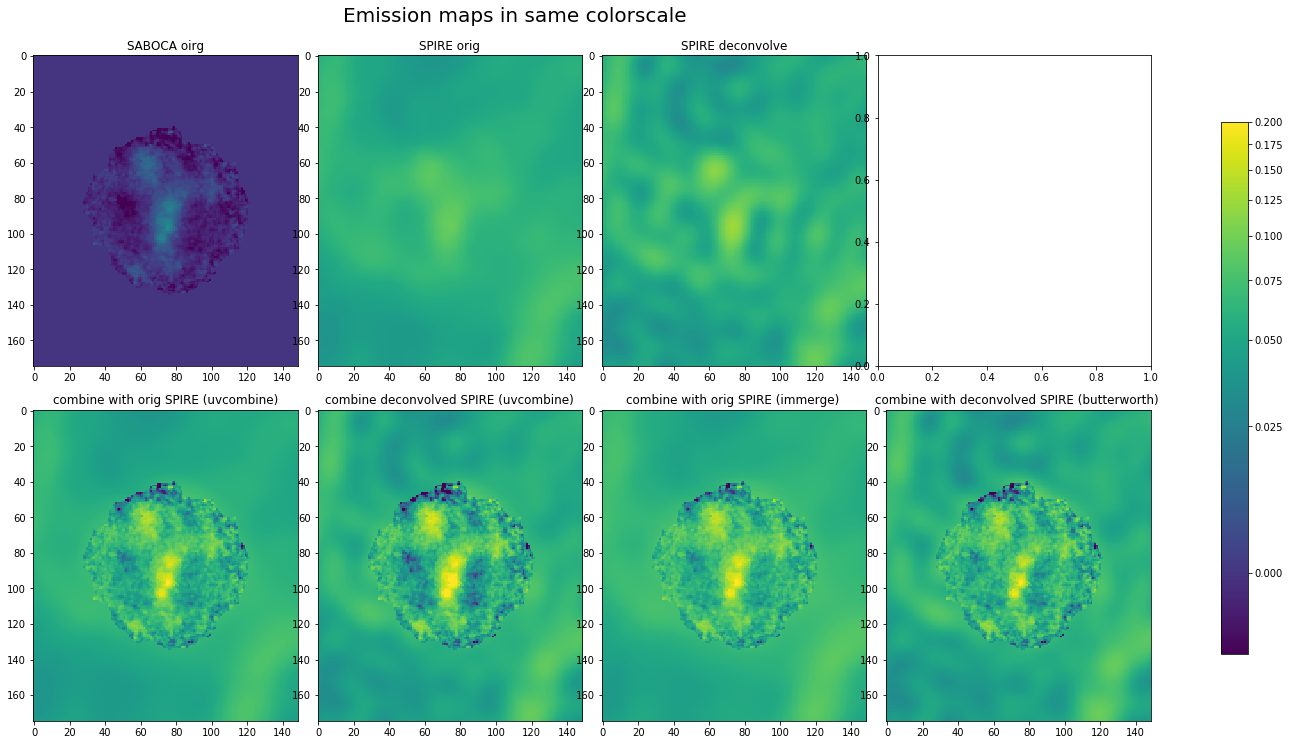

(-0.01, 0.2) 72 27 18


In [109]:
plt.clf()
from astropy.visualization import (MinMaxInterval, AsinhStretch, ImageNormalize, PercentileInterval,
                                  AsymmetricPercentileInterval)

interval = PercentileInterval(99.995)
interval = AsymmetricPercentileInterval(10.5, 100)
image = saboca_orig
# Create an ImageNormalize object
norm = ImageNormalize(image, interval=interval,
                      stretch=AsinhStretch())


fig, axs = plt.subplots(2,4, figsize=(20, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace =0.01, wspace=0.01)
axs = axs.ravel()

Zm = np.ma.masked_where(saboca_orig < 0, saboca_orig)
cmap = plt.get_cmap('viridis')
cmap.set_bad(color = 'white', alpha = 1.)

im=axs[0].imshow(saboca_orig*((8/9.86)**2.), cmap=cmap,norm=norm,vmin=-0.01,vmax=0.2)
axs[0].set_title('SABOCA oirg')
cm_ct = plt.get_cmap('Reds')
NUM_COLORS = 10
#axs[0].contour(saboca_orig*((8/9.86)**2.), np.linspace(0.01,0.3,30),colors=[cm_ct(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
clim=im.properties()['clim']
cmap = plt.cm.viridis

axs[1].imshow(spire_orig, cmap=cmap,clim=clim,norm=norm)
#axs[1].contour(spire_orig, np.linspace(0.03,0.2,10),colors=[cm_ct(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

axs[1].set_title('SPIRE orig')
axs[2].imshow(deconv_spire_orig, cmap=cmap,clim=clim,norm=norm)
axs[2].set_title('SPIRE deconvolve')
axs[4].imshow(comb_nodecon/(np.pi*9.86**2/(4*np.log(2))), cmap=cmap,clim=clim,norm=norm)
axs[4].set_title(r'combine with orig SPIRE (uvcombine)')
axs[5].imshow((comb_decon)/(np.pi*9.86**2/(4*np.log(2))), cmap=cmap,clim=clim,norm=norm)
axs[5].set_title('combine deconvolved SPIRE (uvcombine)')
#axs[5].contour(comb_bw/(np.pi*9.86**2/(4*np.log(2))), np.linspace(0.01,0.3,30),colors=[cm_ct(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

axs[6].imshow(comb_miriad/(np.pi*9.86**2/(4*np.log(2))), cmap=cmap,clim=clim,norm=norm)
axs[6].set_title('combine with orig SPIRE (immerge) ')


axs[7].imshow(comb_bw/(np.pi*9.86**2/(4*np.log(2))), cmap=cmap,clim=clim,norm=norm)
axs[7].set_title('combine with deconvolved SPIRE (butterworth) ')
#axs[7].contour(comb_miriad/(np.pi*9.86**2/(4*np.log(2))),np.linspace(0.01,0.3,30),colors=[cm_ct(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

plt.tight_layout()
plt.suptitle('Emission maps in same colorscale\n',x=0.35,y=1.03,size=20)

fig.colorbar(im, ax=axs.ravel().tolist(),shrink=0.8)
plt.show()
print clim, np.sum(comb_decon<0),np.sum(comb_nodecon<0),np.sum(comb_miriad<0)

__The combined image with deconvolved SPIRE have ~500 pixels of negative values__. 
The other two have ~50

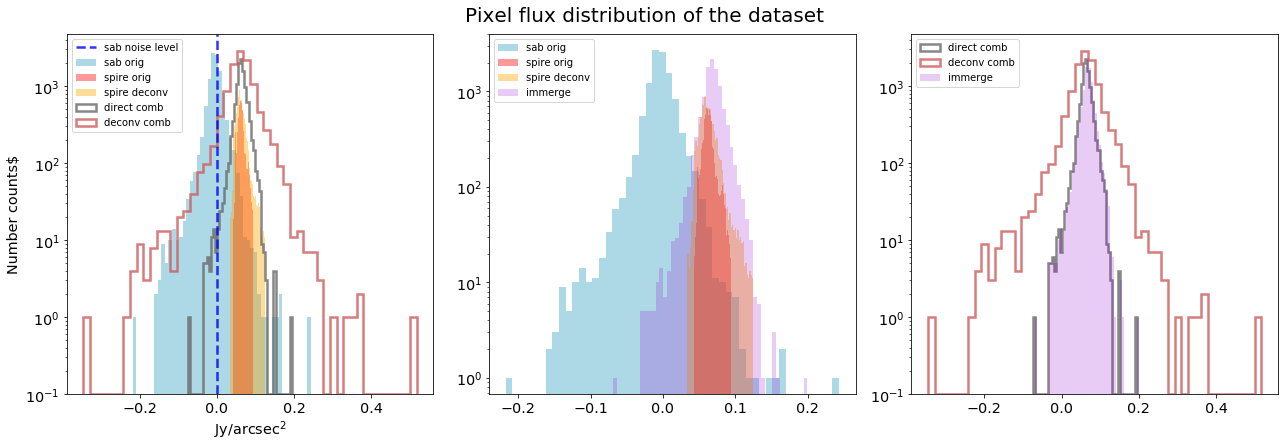

In [92]:
fig,axs = plt.subplots(1,3, figsize=(18, 6), facecolor='w', edgecolor='k')

NBINS = 50
cond = [saboca_orig!=0]

saboca_hist = axs[0].hist(saboca_orig[cond].flatten(), NBINS,log=True, facecolor='lightblue',label='sab orig')

spire_hist = axs[0].hist(spire_orig[cond].flatten(), NBINS,log=True, facecolor='red',alpha=0.4,label='spire orig')
spire_deconv_hist = axs[0].hist(deconv_spire_orig[cond].flatten(), NBINS,log=True, facecolor='orange',alpha=0.4,label='spire deconv')
direct_hist = axs[0].hist((comb_nodecon[cond]/(np.pi*8.0**2/(4*np.log(2)))).flatten(), NBINS,log=True, facecolor='none',alpha=0.8,histtype='step',edgecolor='dimgray',linewidth=2.5,label='direct comb')
deconv_hist = axs[0].hist((comb_decon[cond]/(np.pi*8.0**2/(4*np.log(2)))).flatten(), NBINS,log=True, facecolor='none',alpha=0.8,histtype='step',edgecolor='indianred',linewidth=2.5,label='deconv comb')
axs[0].axvline(x=rms_saboca/(np.pi*8.0**2/(4*np.log(2))),linestyle='--',color='blue',alpha=0.8,linewidth=2.5,label='sab noise level')

saboca_hist = axs[1].hist(saboca_orig[cond].flatten(), NBINS,log=True, facecolor='lightblue',label='sab orig')
spire_hist = axs[1].hist(spire_orig[cond].flatten(), NBINS,log=True, facecolor='red',alpha=0.4,label='spire orig')
spire_deconv_hist = axs[1].hist(deconv_spire_orig[cond].flatten(), NBINS,log=True, facecolor='orange',alpha=0.4,label='spire deconv')
immerge_hist = axs[1].hist((comb_miriad[cond]/(np.pi*8.0**2/(4*np.log(2)))).flatten(), NBINS,log=True, facecolor='darkviolet',alpha=0.2,label='immerge')

direct_hist = axs[2].hist((comb_nodecon[cond]/(np.pi*8.0**2/(4*np.log(2)))).flatten(), NBINS,log=True, facecolor='none',alpha=0.8,histtype='step',edgecolor='dimgray',linewidth=2.5,label='direct comb')
deconv_hist = axs[2].hist((comb_decon[cond]/(np.pi*8.0**2/(4*np.log(2)))).flatten(), NBINS,log=True, facecolor='none',alpha=0.8,histtype='step',edgecolor='indianred',linewidth=2.5,label='deconv comb')
immerge_hist = axs[2].hist((comb_miriad[cond]/(np.pi*8.0**2/(4*np.log(2)))).flatten(), NBINS,log=True, facecolor='darkviolet',alpha=0.2,label='immerge')


axs[0].legend(loc=2,fontsize=10)
axs[0].set_xlabel('$\mathrm{Jy/arcsec^{2}}$')
axs[0].set_ylabel('Number counts$')

axs[1].legend(loc=2,fontsize=10)
axs[2].legend(loc=2,fontsize=10)
plt.tight_layout()
plt.suptitle('Pixel flux distribution of the dataset',x=0.5,y=1.03,size=20)

In [17]:
#the percentage of negative values of SABOCA original image
#np.float(np.sum(saboca_orig[cond]<0.))/saboca_orig[cond].size
print np.float((comb_bw[comb_bw<0]).size)/(comb_bw.size)
print np.float((comb_decon[comb_decon<0]).size)/(comb_decon.size)
print 1./sn_scale_nodec['mean_sc']
print 1./sn_scale_dec['mean_sc']

0.00115052732502
0.00199424736337
1.12242326483
3.62866600634


__In what follows we compare the IMMERGE combined image flux vs. SABOCA image pixel-by-pixel:__

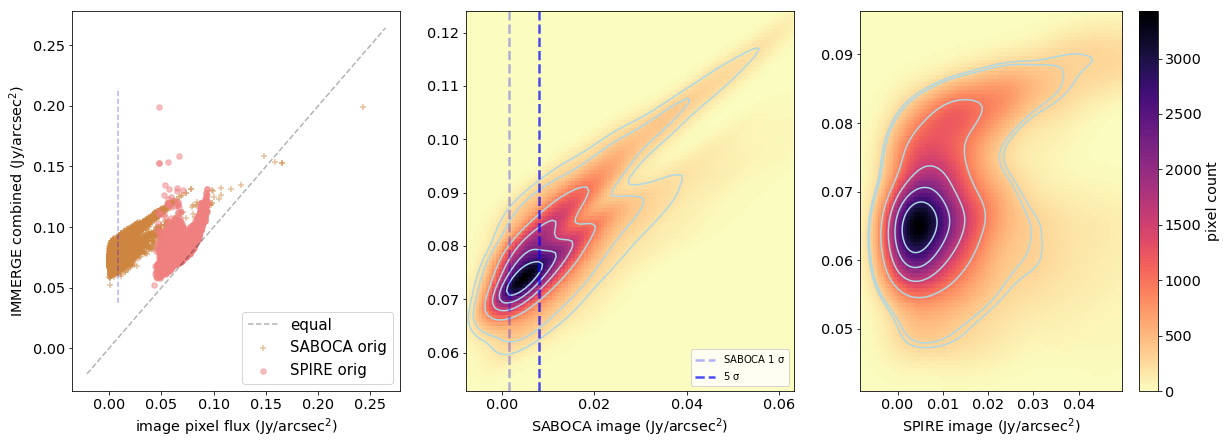

In [94]:
comb = comb_miriad/(np.pi*8.0**2/(4*np.log(2)))
spire = spire_orig
fig, ax = plt.subplots(1,3, figsize=(20, 7), facecolor='w', edgecolor='k')
ax[0].scatter(saboca_orig[np.logical_and(saboca_orig>0,comb>0)], comb[np.logical_and(saboca_orig>0,comb>0)],
           s=30, c='peru',alpha=0.5, marker='+',label='SABOCA orig')
ax[0].scatter(spire_orig[np.logical_and(saboca_orig>0,comb>0)], comb[np.logical_and(saboca_orig>0,comb>0)],
           s=30, c='lightcoral',alpha=0.5, marker='o',label='SPIRE orig')



#axs[0].axvline(x=rms_saboca*5/(np.pi*8.0**2/(4*np.log(2))),linestyle='--',color='blue',alpha=0.8,linewidth=10.5)
ax[0].plot(np.repeat(rms_saboca*5/(np.pi*8.0**2/(4*np.log(2))),1000),
            np.linspace(ax[0].get_ylim()[0],ax[0].get_ylim()[1],1000),'b--',alpha=0.3)
equ = np.linspace(np.array([ax[0].get_ylim(),ax[0].get_xlim()]).min(), 
                  np.array([ax[0].get_ylim(),ax[0].get_xlim()]).max(),20)
ax[0].plot(equ, equ, 'k--',alpha=0.3,label='equal')
ax[0].legend(loc=4, fontsize=15)


#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_xlim(0.0,0.10)
ax[0].set_xlabel('image pixel flux ($\mathrm{Jy/arcsec^{2})}$')
ax[0].set_ylabel('IMMERGE combined ($\mathrm{Jy/arcsec^{2})}$')

from scipy.stats import gaussian_kde
threshold = 200
bins = 100
x = saboca_orig[np.logical_and(saboca_orig>0,comb>0)]
y = comb[np.logical_and(saboca_orig>0,comb>0)]
points = np.vstack([x,y])
# perform kernel density estimate
kde = gaussian_kde(points)
z = kde(points)
# mask points above density threshold
x = np.ma.masked_where(z < threshold, x)
y = np.ma.masked_where(z < threshold, y)

ax[1].scatter(x, y, c='gray', marker='.',alpha=0.0)
# get bounds from axes
xmin, xmax = ax[1].get_xlim()
ymin, ymax = ax[1].get_ylim()

# prepare grid for density map
xedges = np.linspace(xmin, xmax, bins)
yedges = np.linspace(ymin, ymax, bins)
xx, yy = np.meshgrid(xedges, yedges)
gridpoints = np.array([xx.ravel(), yy.ravel()])

# compute density map
zz = np.reshape(kde(gridpoints), xx.shape)

# plot density map
im = ax[1].imshow(zz, cmap='magma_r', interpolation='nearest',
               origin='lower', extent=[xmin, xmax, ymin, ymax],aspect='auto')

# plot threshold contour, from threshold to 0.1x, 0.3x, 0.5x, 0.7x, 0.8xPeak value
cs = ax[1].contour(xx, yy, zz, levels=np.hstack([threshold,zz.max()*np.linspace(0.1,1,6)]), colors='lightblue')
ax[1].plot(np.repeat(rms_saboca/(np.pi*8.0**2/(4*np.log(2))),1000),
            np.linspace(ax[1].get_ylim()[0],ax[1].get_ylim()[1],1000),'b--',alpha=0.3,linewidth=2.5, label='SABOCA 1 $\mathrm{\sigma}$')

ax[1].plot(np.repeat(rms_saboca*5/(np.pi*8.0**2/(4*np.log(2))),1000),
            np.linspace(ax[1].get_ylim()[0],ax[1].get_ylim()[1],1000),'b--',alpha=0.7,linewidth=2.5, label='5 $\mathrm{\sigma}$')
#ax[1].plot(np.linspace(ax[1].get_ylim()[0],ax[1].get_ylim()[1],1000),
#            np.linspace(ax[1].get_ylim()[0],ax[1].get_ylim()[1],1000),'k--',alpha=0.3,linewidth=2.5)
ax[1].legend(loc=4)

cbar = fig.colorbar(im, orientation='vertical')
cbar.set_label('pixel count')
#ax[1].colorbar(im,label='pixel count',pad=0.05)
ax[1].set_xlabel('SABOCA image ($\mathrm{Jy/arcsec^{2})}$')



x = saboca_orig[np.logical_and(saboca_orig>0,comb>0)]
y = spire[np.logical_and(saboca_orig>0,comb>0)]
points = np.vstack([x,y])
# perform kernel density estimate
kde = gaussian_kde(points)
z = kde(points)
# mask points above density threshold
x = np.ma.masked_where(z < threshold, x)
y = np.ma.masked_where(z < threshold, y)

ax[2].scatter(x, y, c='gray', marker='.',alpha=0.0)
# get bounds from axes
xmin, xmax = ax[2].get_xlim()
ymin, ymax = ax[2].get_ylim()

# prepare grid for density map
xedges = np.linspace(xmin, xmax, bins)
yedges = np.linspace(ymin, ymax, bins)
xx, yy = np.meshgrid(xedges, yedges)
gridpoints = np.array([xx.ravel(), yy.ravel()])

# compute density map
zz = np.reshape(kde(gridpoints), xx.shape)

# plot density map
im = ax[2].imshow(zz, cmap='magma_r', interpolation='nearest',
               origin='lower', extent=[xmin, xmax, ymin, ymax],aspect='auto')

cs = ax[2].contour(xx, yy, zz, levels=np.hstack([threshold,zz.max()*np.linspace(0.1,1,6)]), colors='lightblue')
ax[2].legend(loc=4)
#fig.colorbar(im,label='pixel count',pad=0.05)
ax[2].set_xlabel('SPIRE image ($\mathrm{Jy/arcsec^{2})}$')



In [62]:
# %load /Users/yuxinlin/pyscript/sm_orig.py
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel 
target_resolution = 30.3
native_beamsize = 8.0
pixel_size = 1.85
FWHM_TO_SIGMA = 1./np.sqrt(8*np.log(2))

kernel_size=((target_resolution*FWHM_TO_SIGMA)**2-(native_beamsize*FWHM_TO_SIGMA)**2)**0.5
pixel_n = kernel_size/pixel_size
gauss_kernel =Gaussian2DKernel(pixel_n)
smoothed_comb = convolve(comb, gauss_kernel,normalize_kernel=True)


from scipy import linspace, polyval, polyfit, sqrt, stats, randn
#Linear regressison -polyfit - polyfit can be used other orders polys
x = spire[np.logical_and(saboca_orig>0,comb>0)]
y = smoothed_comb[np.logical_and(saboca_orig>0,comb>0)]

(ar,br)=polyfit(x,y,1)
xr=polyval([ar,br],x)
#compute the mean square error
err=sqrt(sum((xr-x)**2)/len(x))

print('Linear regression using polyfit')
print('\nregression: a=%.2f b=%.2f, ms error= %.3f' % (ar,br,err))

(a_s,b_s,r,tt,stderr)=stats.linregress(x,y)
print('Linear regression using stats.linregress')
print('\nregression: a=%.2f b=%.2f, std error= %.3f' % (a_s,b_s,stderr))

Linear regression using polyfit

regression: a=1.02 b=0.00, ms error= 0.006
Linear regression using stats.linregress

regression: a=1.02 b=0.00, std error= 0.002


__This indicates the combined image are consistent with SPIRE fluxes with an positive offset of 0.01 Jy/arcsec$^{2}$. Note that the SABOCA image noise level is 0.0016 Jy/arcsec$^{2}$__

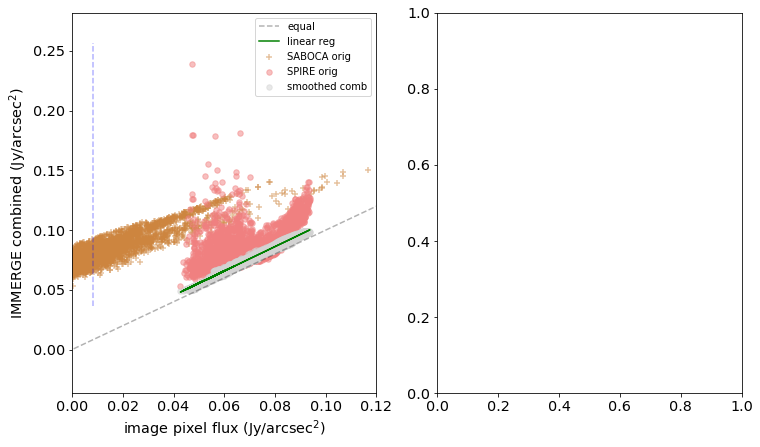

In [63]:
fig, ax = plt.subplots(1,2, figsize=(12, 7), facecolor='w', edgecolor='k')
ax[0].scatter(saboca_orig[np.logical_and(saboca_orig>0,comb>0)], comb[np.logical_and(saboca_orig>0,comb>0)],
           s=30, c='peru',alpha=0.5, marker='+',label='SABOCA orig')
ax[0].scatter(spire_orig[np.logical_and(saboca_orig>0,comb>0)], comb[np.logical_and(saboca_orig>0,comb>0)],
           s=30, c='lightcoral',alpha=0.5, marker='o',label='SPIRE orig')


ax[0].scatter(spire[np.logical_and(saboca_orig>0,comb>0)], smoothed_comb[np.logical_and(saboca_orig>0,comb>0)],
           s=30, c='lightgray',alpha=0.5, marker='o',label='smoothed comb')


#axs[0].axvline(x=rms_saboca*5/(np.pi*8.0**2/(4*np.log(2))),linestyle='--',color='blue',alpha=0.8,linewidth=10.5)
ax[0].plot(np.repeat(rms_saboca*5/(np.pi*8.0**2/(4*np.log(2))),1000),
            np.linspace(ax[0].get_ylim()[0],ax[0].get_ylim()[1],1000),'b--',alpha=0.3)
equ = np.linspace(np.array([ax[0].get_ylim(),ax[0].get_xlim()]).min(), 
                  np.array([ax[0].get_ylim(),ax[0].get_xlim()]).max(),20)
ax[0].plot(equ, equ, 'k--',alpha=0.3,label='equal')

ax[0].set_xlim(0.0,0.12)
ax[0].set_xlabel('image pixel flux ($\mathrm{Jy/arcsec^{2})}$')
ax[0].set_ylabel('IMMERGE combined ($\mathrm{Jy/arcsec^{2})}$')
ax[0].plot(x,xr,linewidth=1.5,linestyle='-',color='green',label='linear reg')
ax[0].legend(loc=1, fontsize=10)


__Test with combining fiducial 350 $\mu$m image derived from LABOCA+PLANCK image with Td = 20 K, beta = 1.8 of resolution 19$"$__

In [35]:
#generate fiducial 350 um image
from sed_model_lumi import sed_model

In [33]:
np.sum(check_listsat)
calidict_9046 = (calibration_dict)
#calidict_8555 = calibration_dict
#calidict_8546 = calibration_dict
print check_listsat
#print len(calidict_9046), len(calidict_8555), len(calidict_8546)
#values = np.hstack([calidict_8546.values(),calidict_8555.values(),calidict_9046.values()])

[ 0.]


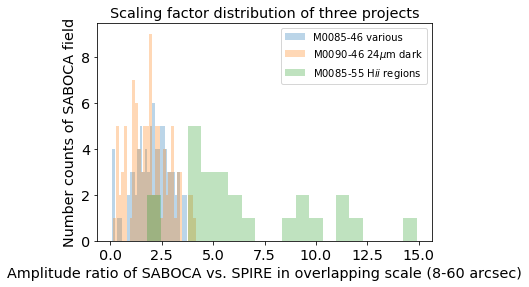

In [42]:
plt.hist(calidict_8546.values(), bins=30,label='M0085-46 various',alpha=0.3,)
plt.hist(calidict_9046.values(), bins=30, label='M0090-46 24$\mu$m dark',alpha=0.3)
plt.hist(calidict_8555.values(), bins=20,label='M0085-55 H$ii$ regions',alpha=0.3)

plt.ylabel('Number counts of SABOCA field')
plt.xlabel('Amplitude ratio of SABOCA vs. SPIRE in overlapping scale (8-60 arcsec)')
plt.title('Scaling factor distribution of three projects')
plt.legend()

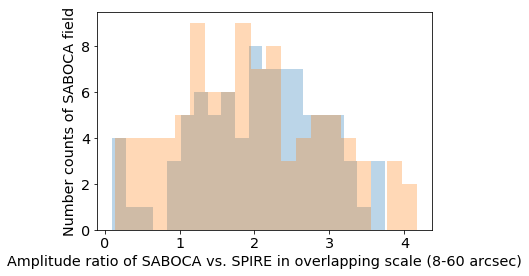

In [44]:
plt.hist(calidict_8546.values(), bins=20,label='M0085-46 various',alpha=0.3,)
plt.hist(calidict_9046.values(), bins=20, label='M0090-46 24$\mu$m dark',alpha=0.3)

plt.ylabel('Number counts of SABOCA field')
plt.xlabel('Amplitude ratio of SABOCA vs. SPIRE in overlapping scale (8-60 arcsec)')

In [54]:
all_immerge_files = glob.glob1(r'./','*_miriad_merge_1027.fits')
all_first_sedfiles = glob.glob1(r'/Users/yuxinlin/saboca_sources/first_sed_no70_betafixed/', '*Td*fits')

all_exit_350 = [i[:-23] for i in all_immerge_files]
all_exit_firstsed = [i[:-20] for i in all_first_sedfiles]
nocomb_350 = []
nofirstsed = []
for sn in sourcename:
    if sn not in all_exit_350:
        nocomb_350 = np.append(nocomb_350, sn)
    if sn not in all_exit_firstsed:
        nofirstsed = np.append(nofirstsed, sn)
print nofirstsed, '\n',nocomb_350

['AG008.71-0.41' 'AG12.89-0.28' 'AG31.58+0.08' 'AG326.61+0.81'
 'AG332.36-0.44' 'AG340.97-1.02' 'AG341.94-0.18' 'AG350.41-0.06'
 'AG354.94-0.54' 'AG38.37-0.15' 'AG300.95+0.90' 'AG303.12-0.97'
 'AG304.71+0.60' 'AG326.49+0.88' 'AG326.61+0.81' 'AG327.29-0.19'
 'AG331.51+0.20' 'AG334.53-0.23' 'AG336.05-0.83' 'AG339.88-0.94'
 'AG342.31+0.31' 'AG348.66-0.94' 'AG350.27+0.12' 'AG12.8-0.2' 'AG31.4+0.3'
 'AG327.3-0.6' 'AG348.7-1.0' 'AG351.6-0.4' 'AG351.8-0.5' 'AG49.5-0.4A'
 'AG49.5-0.4B'] 
['AG326.61+0.81' 'AG340.97-1.02' 'AG341.94-0.18' 'AG354.94-0.54'
 'AG300.95+0.90' 'AG303.12-0.97' 'AG304.71+0.60' 'AG326.49+0.88'
 'AG326.61+0.81' 'AG336.05-0.83' 'AG339.88-0.94' 'AG342.31+0.31'
 'AG348.66-0.94' 'AG348.7-1.0']


In [82]:
(np.array(saboca_orig)).shape
np.unravel_index((np.array(saboca_orig)).argmax(),(np.array(saboca_orig)).shape)[0]

61